# Importing the libraries

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from gplearn.genetic import SymbolicRegressor
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import seaborn as sns
from gplearn.genetic import SymbolicRegressor
from gplearn.functions import make_function
import re
import os

# Obtaining Data and Preprocessing 

In [6]:
#Reading the CSV file
# Set the path to your folder
folder_path = "Data"

# Regex pattern to match files like dsgdb9nsd_000001.xyz
pattern = re.compile(r"dsgdb9nsd_(\d{6})\.xyz")

# Find and sort the files by their numeric part
files = []
for filename in os.listdir(folder_path):
    match = pattern.match(filename)
    if match:
        number = int(match.group(1))
        files.append((number, filename))

# Sort files by number
files.sort()
molecules = []
for number, filename in files:
    file_path = os.path.join(folder_path, filename) 
    with open(file_path, 'r') as f:
        lines = f.readlines()
        num_atoms = {"num_atoms" : int(lines[0].strip())}
        
        # Line 1 
        vars = lines[1].split()
        
        # Line 2
        A, B, C = {"Arot" : float(vars[2])}, {"Brot" : float(vars[3])}, {"Crot" : float(vars[4])} # GHz
        mu = {"mu" : float(vars[5])} # Dipole moment
        alpha = {"alpha" : float(vars[6])} # Isotropic polarizability
        eHOMO = {"eHOMO" : float(vars[7])} # HOMO energy
        eLUMO = {"eLUMO" : float(vars[8])} # LUMO energy
        eGap = {"eGap" : float(vars[9])} # Gap energy 
        R2 = {"R2" : float(vars[10])} # Electronic spatial extent
        zpve = {"zpve" : float(vars[11])} # zero-point vibrational energy
        U0 = {"U0" : float(vars[12])} # internal energy at 0K
        U = {"U298" : float(vars[13])} # internal energy at 298.15 K
        H = {"H298" : float(vars[14])} # enthalpy at 298.15 K 
        G = {"G298" : float(vars[15])} # Free Gibbs energy at 298.15 K 
        Cv = {"Cv298" : float(vars[16])} # Constant Volume heat capacity at 298.15 K
        S = {"S298" : -(float(vars[15]) - float(vars[14])) / 298.15 * 1000}
        # Elements (Line 3 -> Line n + 3) where n is the number of elements
        index = 2
        elems_count = dict()
        while True:
            element = lines[index].strip().split("\t")[0]
            try:
                float(element)  # can be int or float
                break
            except ValueError: # it is a string 
                index += 1
                if element in elems_count:
                    elems_count[element] += 1
                else:
                    elems_count[element] = 1
        # Line n + 4: for now it is ignored
        harmonic_frequencies = {"harmonic_freq" : [float(freq) for freq in lines[index].strip().split("\t")]}
        harmonic_freq_max = {"harmonic_freq_max" : max(max(harmonic_frequencies.values()))}
        harmonic_freq_min = {"harmonic_freq_min" : min(min(harmonic_frequencies.values()))}
        combined_output = {**A, **B, **C, **mu, **alpha, **eHOMO, **eLUMO, **eGap, **R2, **zpve, **U0, **U,
                           **H, **G, ** Cv, **num_atoms, **elems_count, **S, **harmonic_freq_max, **harmonic_freq_min}
        molecules.append(combined_output)

# Fill the missing values with zeros
df = pd.DataFrame(molecules)
df.fillna(value=0, inplace=True)

# ColorMap colors

In [8]:
def get_colors(n, colormap_name="viridis"):
    cmap = plt.get_cmap(colormap_name)
    colors = [cmap(i / (n - 1)) for i in range(n)]
    return colors

# Analyzing a target based on all features except the target

Here I was trying to see how good the ML model can be at predicting specific features given a lot of information about a molecule. As we can observe, the RandomForests model with GridSearch performs really well on all the desires thermodynamic features. Even more interestingly, the importance of the features observed strongly correlates with the laws of physical chemistry. So our model unknowingly was able to determine that dG = dH - TdS or find out that Cv = -T * dS/dT. On the other hand, it struggled with determined the most important features for a dipole moment which does not have a clear formula in physical chemistry, and indeed, we see a lot of features contributing to the result with a far smaller accuracy.

In [10]:
def analyze_features(targets=["Cv298"], use_columns=[], drop_columns=[], colormap="orange", verbose=True):
    num_targets = len(targets)
    fig, axes = plt.subplots(1, num_targets, figsize=(8 * num_targets, 6), squeeze=False)
    colors = get_colors(num_targets)
    for i, target in enumerate(targets):
        y = df[target]
        raw_X = df.drop(columns=[target])
        if len(use_columns) == 0: 
            X = raw_X.drop(columns=drop_columns)
        else:
            X = raw_X[use_columns]

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42)

        est = RandomForestRegressor(n_estimators=100, 
                                    criterion='squared_error', 
                                    random_state=1, 
                                    n_jobs=-1)

        param_grid = {
            'n_estimators': [50, 100, 150],
            'max_depth': [None, 5, 10, 15],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 3, 5],
        }

        grid_search = GridSearchCV(
            estimator=est,
            param_grid=param_grid,
            cv=5,
            n_jobs=-1
        )

        grid_search.fit(X_train, y_train)
        best_est = grid_search.best_estimator_
        best_est.fit(X_train, y_train)
        y_train_pred = best_est.predict(X_train)
        y_test_pred = best_est.predict(X_test)

        if verbose:
            print(f"\n📊 Target: {target}")
            print('MSE train: %.3e, test: %.3e' % (
                mean_squared_error(y_train, y_train_pred),
                mean_squared_error(y_test, y_test_pred)))
            print('R^2 train: %.3f, test: %.3f' % (
                r2_score(y_train, y_train_pred),
                r2_score(y_test, y_test_pred)))

        # Plot feature importances
        importances = best_est.feature_importances_
        feature_contributions = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)

        ax = axes[0, i]
        feature_contributions.plot(kind='barh', x='Feature', y='Importance', ax=ax, color=colors[i])
        ax.set_title(f"Feature Importances\nTarget: {target}", fontsize=14)
        ax.invert_yaxis()
        ax.tick_params(axis='y', labelsize=12)
        ax.tick_params(axis='x', labelsize=12)
        ax.set_xlabel("Importance", fontsize=12)
        ax.set_ylabel("Features", fontsize=12)

    plt.tight_layout()
    plt.show()

# HeatMap of features

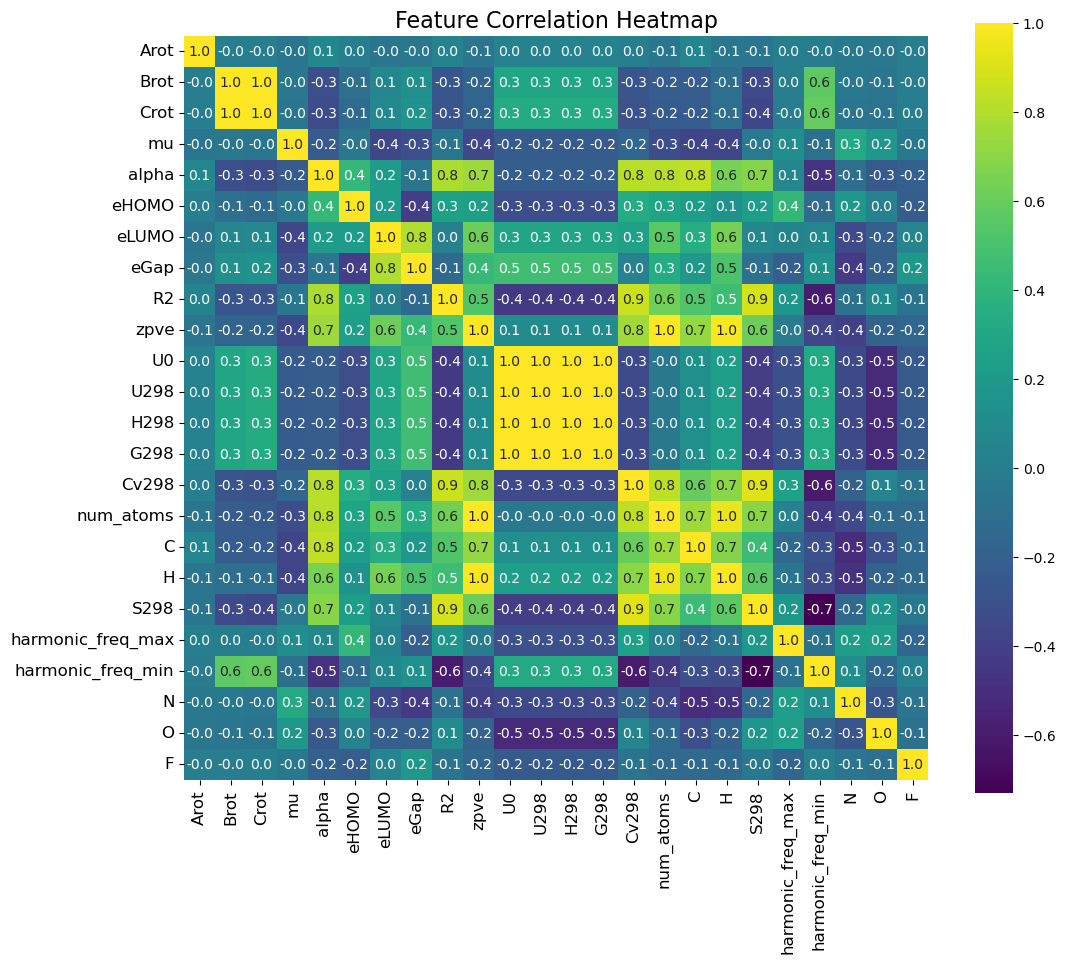

In [113]:
# Compute correlation matrix
corr = df.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='viridis', fmt=".1f", square=True)
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()

## Cv298
Model successfully determined the dependence of constant-volume heat capacity on entropy and the number of atoms. Original formula: Cv = -T * dS / dT, where T is temperature and dS is a change in entropy 

## G298
Model determined a formula similar to the original (G = H - TS, where G is the Gibbs energy, H is enthalpy, T is temperature, and S is entropy), but at the same time not exactly the same. However, the original formula can be derived from the variables provided by the model, so still successful prediction. 

## S298
As indicted above, Cv (constant-volume heat capacity) is dependent on entropy, so the opposite is also true which makes the prediction still successful. 

## U298
Another successful prediction based on the similar prediction above. I will the derivation out for simplicity reasons.

## mu
mu stands for dipole moment, and this physical property does not have a clear formula, as the other ones above. Thus, our model chooses too many variables that are important, overfitting the model.

## eGap
Our model easily detects that the energy gap is a dependent on both ground state and excited state (pretty obvious but it is still important). One thing I am confused about is the fact that them models considers lower energy (ground-state) more important than the excited state. 

## eHOMO
Correct prediction. Same as above with energy gap.

## eLUMO
Same as above.

## Zero point vibrational-energy

This one is pretty interesting, as although there is a formula that uses harmonic vibrational frequencies to calculate vibrational energy, the model seems to have decided to use number of hydrogens as its best guess. It is not completely wrong, as bonds with hydrogens have the highest vibrational energies due to its small reduced mass. I think this is caused by the fact that this dataset only includes organic (C, H, O, F) molecules with very limited number of atoms. However, that's definitely very interesting way to think about this problem from a different perspective


📊 Target: Cv298
MSE train: 6.993e-02, test: 3.603e-01
R^2 train: 0.996, test: 0.973

📊 Target: G298
MSE train: 7.833e-01, test: 3.711e+00
R^2 train: 1.000, test: 0.998

📊 Target: S298
MSE train: 6.703e-07, test: 2.757e-06
R^2 train: 0.994, test: 0.965

📊 Target: U298
MSE train: 8.192e-01, test: 2.904e+00
R^2 train: 1.000, test: 0.999

📊 Target: mu
MSE train: 3.692e-01, test: 1.018e+00
R^2 train: 0.829, test: 0.453

📊 Target: eLUMO
MSE train: 1.086e-05, test: 1.158e-04
R^2 train: 0.996, test: 0.950

📊 Target: eHOMO
MSE train: 1.873e-05, test: 5.685e-05
R^2 train: 0.983, test: 0.948

📊 Target: zpve
MSE train: 2.924e-07, test: 1.164e-06
R^2 train: 1.000, test: 0.999


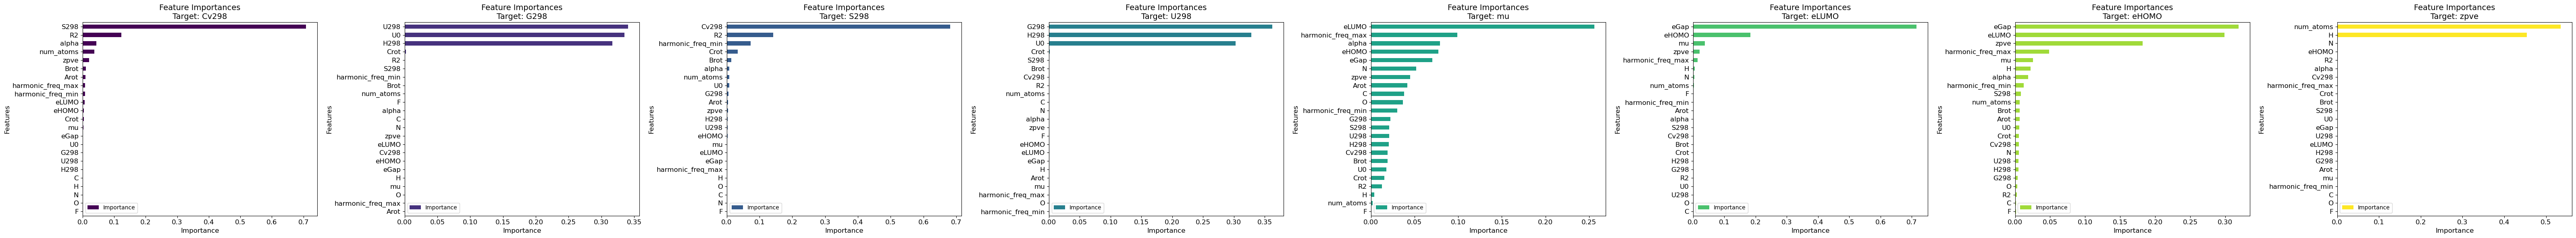

In [142]:
targets = ["Cv298", "G298", "S298", "U298", "mu", "eLUMO", "eHOMO", "zpve"]
analyze_features(targets=targets)

# Testing with only atomic features

Next I decided to reduce the number of features to the minimum, so the model is only trained on the types of atoms that are present in a molecule and their amount, and see how the model will perform. Overall, the results generally agreed with my expectations with the exception of a few that performed overly well (I think I might want to use a different scoring method for those).

## G298 (* different scoring method will be implemented later)

## H298 (* different scoring method will be implemented later)

Enthalpy is total heat content of a system = internal energy + work. Indeed, the first term, internal energy, is dependent on the atom's nature, so the feature importances do make sense. Still, I am surprised by such a high accuracy 

## S298

Entropy, in fact, is less dependent on the atomic nature and more on the total number of atoms, as they usually allow more freedom for a molecule. 

## Cv298

Just like we found out in analysis with all features, Cv is strongly dependent on entropy which is dependent on the number of atoms.

## mu

There is no clear formula for a dipole moment, so it is unsurprising that the model performs so poorly.

## U298 (* different scoring method will be implemented later)

Internal energy is indeed dependent on the atoms' nature, but I do want to use a different scoring method to check. 

## eGap
Interesting result. I am not exactly sure how to interpret from a physical chemistry perspective.

## eLUMO
Same as above.

## eHOMO
Same as above.

## Zero-point vibrational energy

Number of hydrogens is the most important factor for this model when considering vibrational energy which agrees with the previous outputs.


📊 Target: Cv298
MSE train: 2.267e+00, test: 3.140e+00
R^2 train: 0.870, test: 0.769

📊 Target: G298
MSE train: 2.773e+01, test: 1.462e+02
R^2 train: 0.989, test: 0.930

📊 Target: S298
MSE train: 2.636e-05, test: 3.409e-05
R^2 train: 0.751, test: 0.566

📊 Target: U298
MSE train: 2.971e+01, test: 2.067e+02
R^2 train: 0.989, test: 0.901

📊 Target: mu
MSE train: 1.229e+00, test: 1.321e+00
R^2 train: 0.432, test: 0.291

📊 Target: eLUMO
MSE train: 8.444e-04, test: 9.347e-04
R^2 train: 0.671, test: 0.593

📊 Target: eHOMO
MSE train: 3.330e-04, test: 4.015e-04
R^2 train: 0.702, test: 0.633

📊 Target: zpve
MSE train: 1.343e-06, test: 2.011e-06
R^2 train: 0.998, test: 0.998


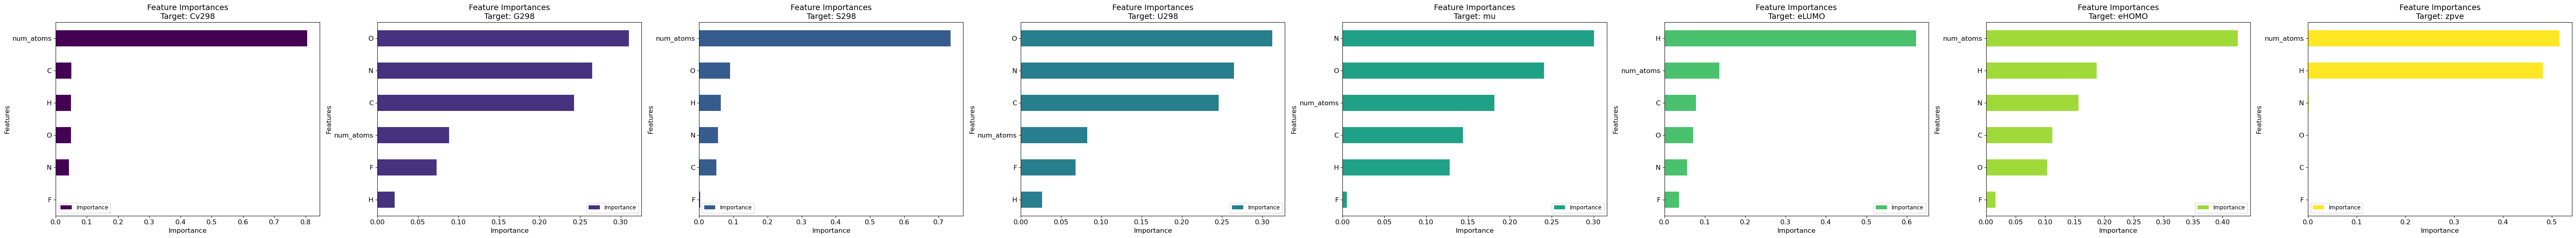

In [160]:
targets = ["Cv298", "G298", "S298", "U298", "mu", "eLUMO", "eHOMO", "zpve"]
cols_used = ["O", "N", "C", "F", "H", "num_atoms"]
analyze_features(targets, use_columns=cols_used)

# Predicting properties for known molecules
To check my hypothesis that scoring is overly high for some metrics, I decided to use a few molecules from the online database. I tried to predict Gibbs energy which is one of overly well performing metrics. As you can observe, although the model provides an approximately correct value for first four examples, it totally fails for other four. On top of that, the predicted values for the first four are still quite far off from the true ones, affirming our hypothesis. 

Interestingly, I have noticed that the model tends to perform worse on organic acids, which it underestimates. That's possibly caused by the negligence of hydrogen bonding which appear in solutions. It is interesting how can we account for it.

In [75]:
cols_used = ["O", "N", "C", "F", "H", "num_atoms"]
est = analyze_feature("G298", use_columns=cols_used, verbose=False)
pred = round(est.predict(np.array([1, 0 , 2, 0 , 4, 7]).reshape(1,-1))[0], 2)

# Acetaldehyde
print("Acetaldehyde")
print("True value: -139.21 ")
print("Predicted:", pred)
print()

# Adenine
print("Adenine")
pred = round(est.predict(np.array([0, 5 , 5, 0 , 5, 15]).reshape(1,-1))[0], 2)
print("True value: -299.56")
print("Predicted", pred)
print()

# Ethanol 
print("Ethanol")
pred = round(est.predict(np.array([1, 0 , 2, 0 , 6, 9]).reshape(1,-1))[0], 2)
print("True value: -174.09")
print("Predicted", pred)
print()

# Propane 
print("Propane")
pred = round(est.predict(np.array([0, 0 , 3, 0 , 8, 11]).reshape(1,-1))[0], 2)
print("True value: -103.85")
print("Predicted", pred)
print()

# Creatine (has an acid part) 
print("Creatine")
pred = round(est.predict(np.array([2, 3 , 4, 0 , 9, 18]).reshape(1,-1))[0], 2)
print("True value: -264.83")
print("Predicted", pred)
print()
      
# Aspartic Acid (two acid parts) 
print("Aspartic Acid")
pred = round(est.predict(np.array([4, 1 , 4, 0 , 7, 16]).reshape(1,-1))[0], 2)
print("True value: -730.15")
print("Predicted", pred)
print()

# Formic Acid
print("Formic Acid")
pred = round(est.predict(np.array([2, 0 , 1, 0 , 2, 5]).reshape(1,-1))[0], 2)
print("True value: -361.43")
print("Predicted", pred)
print()

# Acetic Acid
print("Formic Acid")
pred = round(est.predict(np.array([2, 0 , 2, 0 , 4, 8]).reshape(1,-1))[0], 2)
print("True value: -389.3")
print("Predicted", pred)
print()

Acetaldehyde
True value: -139.21 
Predicted: -152.08

Adenine
True value: -299.56
Predicted -322.52

Ethanol
True value: -174.09
Predicted -156.1

Propane
True value: -103.85
Predicted -130.85

Creatine
True value: -264.83
Predicted -398.59

Aspartic Acid
True value: -730.15
Predicted -366.9

Formic Acid
True value: -361.43
Predicted -224.32

Formic Acid
True value: -389.3
Predicted -229.99



/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names

# PCA Analysis 

In [12]:
def pca_analysis(targets=["Cv298"], use_columns=[], drop_columns=[], colormap="orange", verbose=True):
    num_targets = len(targets)
    fig, axes = plt.subplots(1, num_targets, figsize=(8 * num_targets, 6), squeeze=False)
    for i, target in enumerate(targets):
        raw_X = df.drop(columns=[target])
        if len(use_columns) == 0: 
            X = raw_X.drop(columns=drop_columns)
        else:
            X = raw_X[use_columns]
        
        X_scaled = StandardScaler().fit_transform(X) # Very important to scale before fitting 
        pca = PCA()
        pca.fit(X_scaled)
        
        ax = axes[0, i]
        ax.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', color='orange', label=target, linewidth=3, markersize=10)
        ax.set_xlabel('Number of Principal Components', fontsize=14)
        ax.set_ylabel('Cumulative Explained Variance', fontsize=14)
        ax.set_title('Explained Variance by Components', fontsize=16)
        ax.tick_params(axis='y', labelsize=12)
        ax.tick_params(axis='x', labelsize=12)
        ax.legend(fontsize=14)
        
    plt.tight_layout()
    plt.show()

In [363]:
# 12-13 variables are enough to characterize the system completely

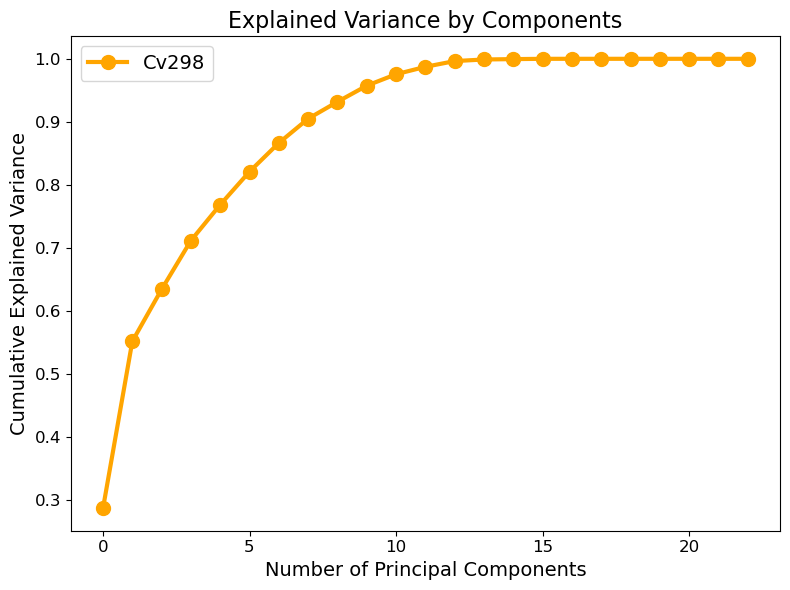

In [365]:
targets = ["Cv298"]
pca_analysis(targets=targets)

In [292]:
# one feature is redundant which makes sense as "num_atoms" can be exactly inferred from the sum of other atom counts

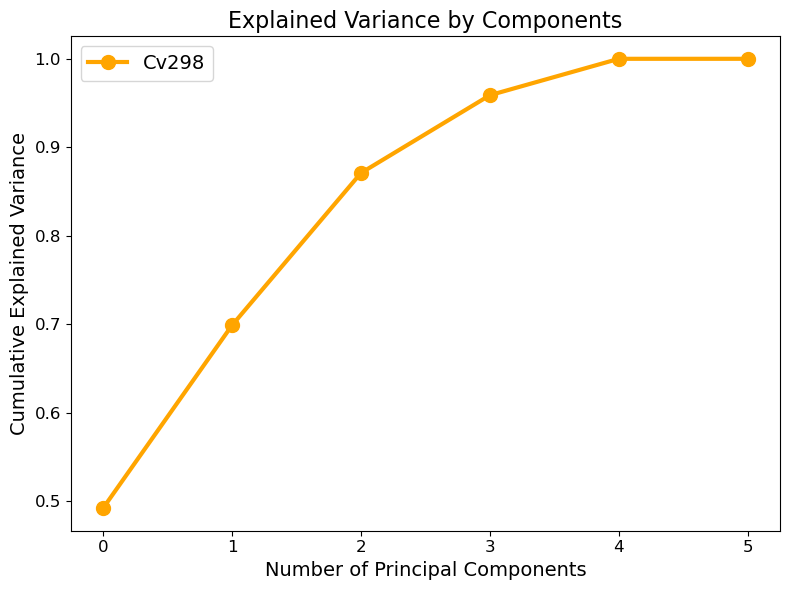

In [367]:
targets = ["Cv298"]
cols_used = ["O", "N", "C", "F", "H", "num_atoms"]
pca_analysis(targets, use_columns=cols_used)

# Pair Plot between the main features that account for 90% of the data variance

/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


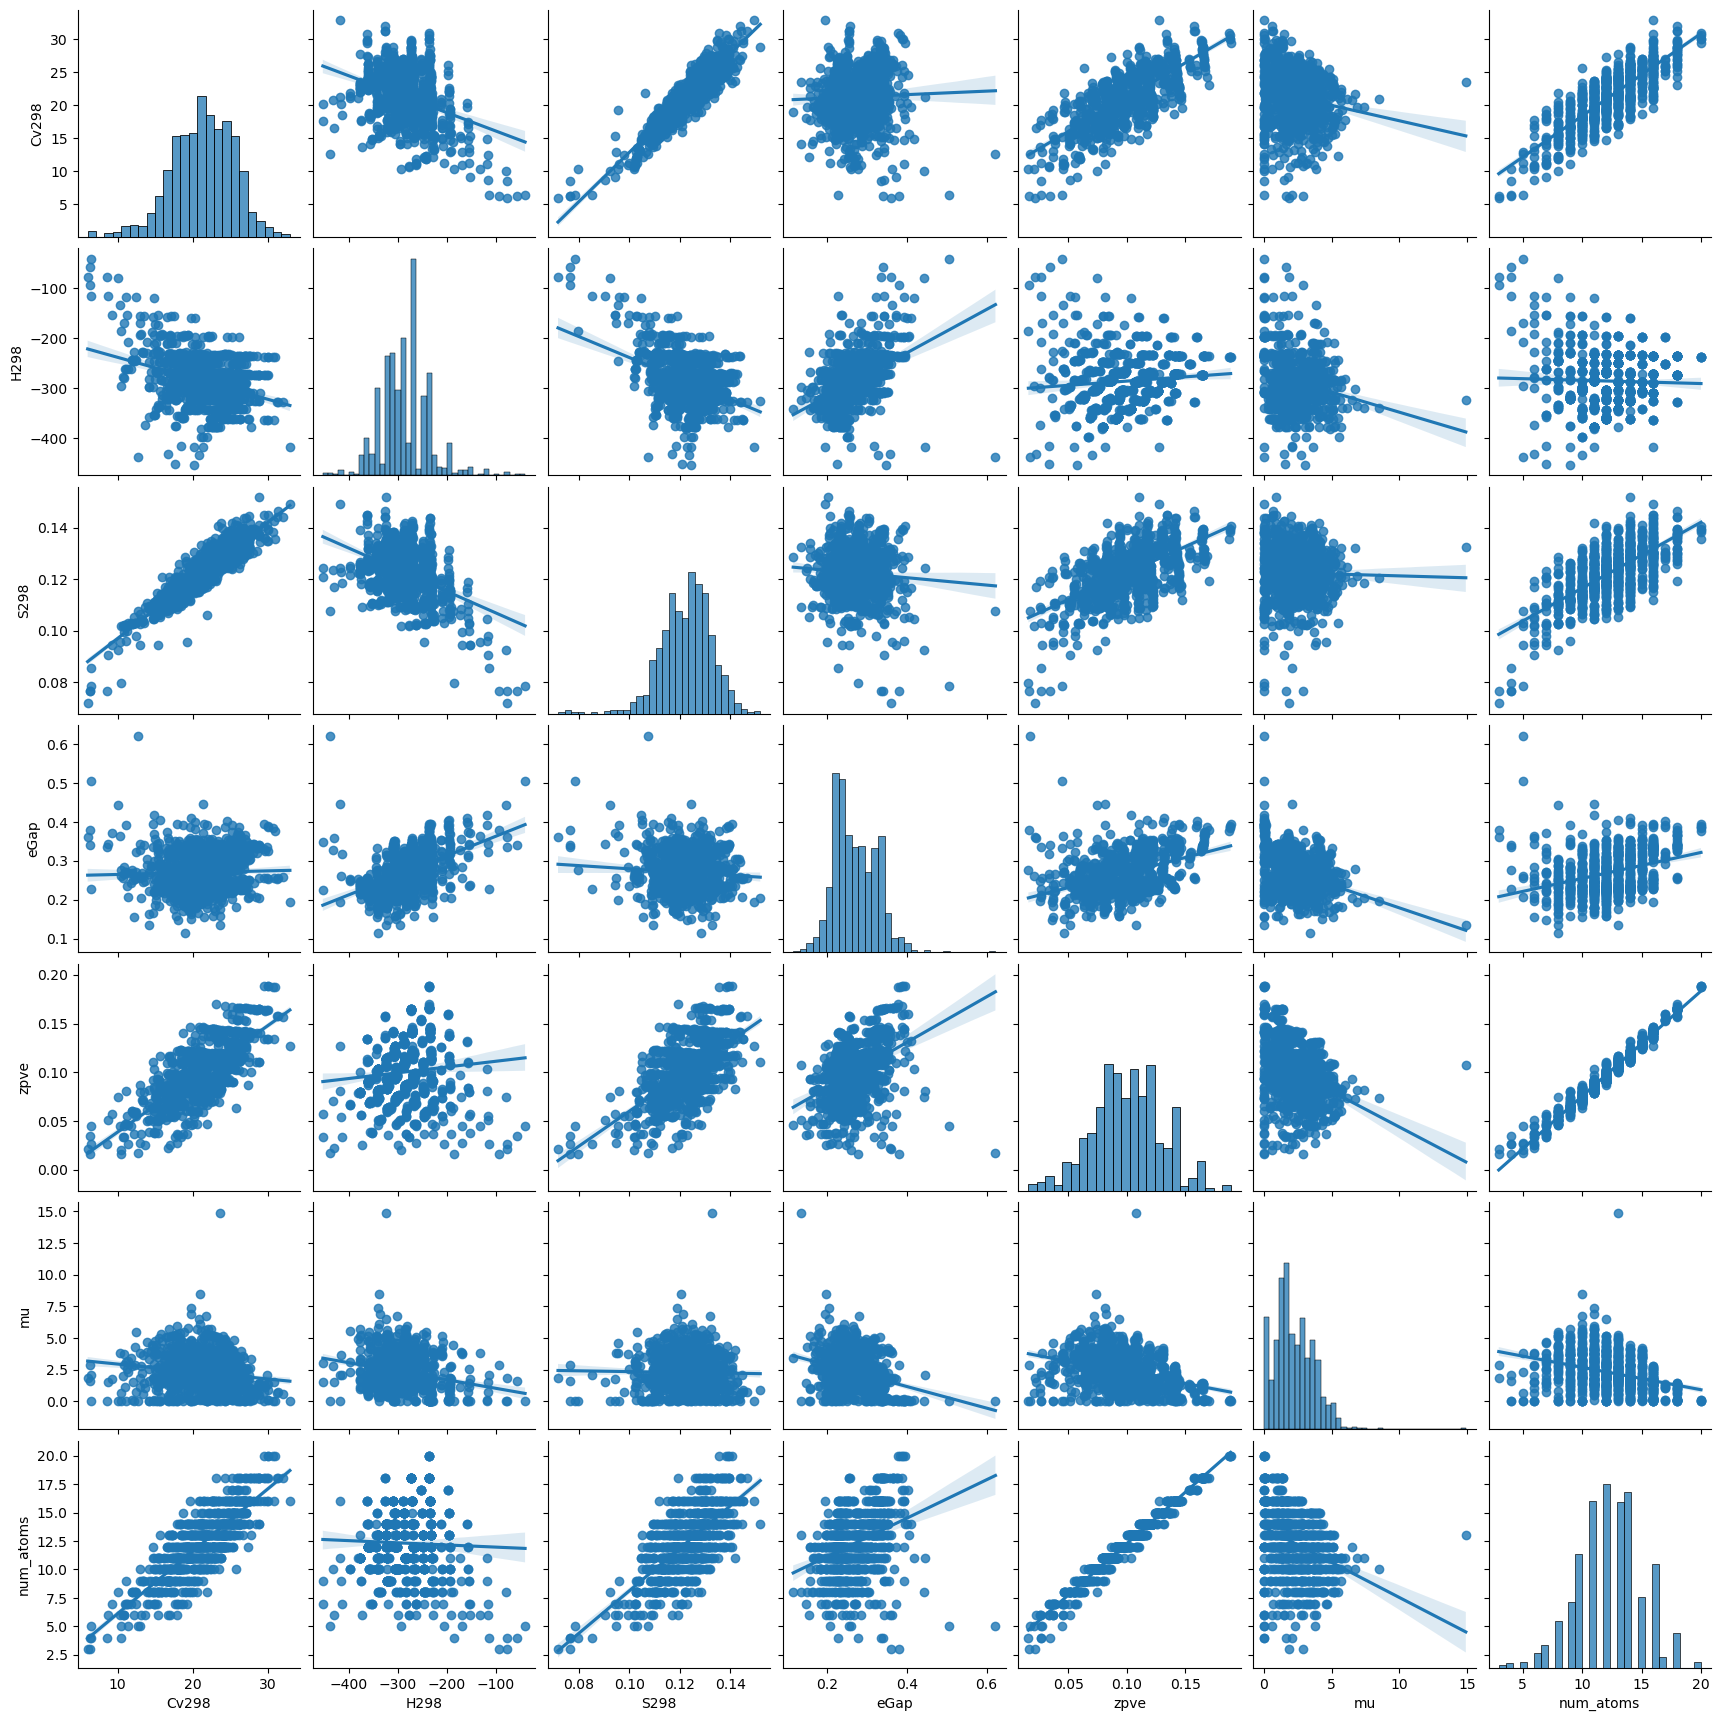

In [332]:
sns.pairplot(df[["Cv298", "H298", "S298", "eGap", "zpve", "mu", "num_atoms"]],  kind="reg")

# Symbolic Regression

# Making custom functions

In [14]:
def sqr(x):
    return np.power(x, 2)
    
def finite_diff(x):
    # simple forward difference: derivative approximation
    diff = np.zeros_like(x)
    diff[1:] = x[1:] - x[:-1]
    return diff

diff_func = make_function(function=finite_diff, name='diff', arity=1)
sqr_func = make_function(function=sqr, name='sqr', arity=1)

In [36]:
def symbolic_reg_analysis(targets=["Cv298"], use_columns=[], drop_columns=[], colormap="orange", verbose=True):
    num_targets = len(targets)

    for i, target in enumerate(targets):
        raw_X = df.drop(columns=[target])
        y = df[target]
        
        if len(use_columns) == 0: 
            X = raw_X.drop(columns=drop_columns)
        else:
            X = raw_X[use_columns]

        # Symbolic Regression
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size=0.2, 
                                                            random_state=42)

        est_gp = SymbolicRegressor(
            population_size=1000,
            generations=20,
            tournament_size=20,
            stopping_criteria=0.01,
            const_range=(-1.0, 1.0),
            init_depth=(2, 6),
            init_method='half and half',
            function_set=('add', 'sub', 'mul', 'div', 'sqrt', 'log', 'abs', 'neg', sqr_func, diff_func),
            parsimony_coefficient=0.01,
            max_samples=0.9,
            verbose=1 if verbose else 0,
            n_jobs=-1,
            random_state=42
        )

        est_gp.fit(X_train, y_train)
        y_pred = est_gp.predict(X_test)

        if verbose:
            print(f"\n📊 Target: {target}")
            print("MSE:", mean_squared_error(y_test, y_pred))
            print("R^2 Score:", r2_score(y_test, y_pred))
            print("Best symbolic expression:")
        
            expr = str(est_gp._program)
            feature_names = X.columns
        
            def replace_token(match):
                var_index = int(match.group(1))
                return feature_names[var_index]
        
            readable_expr = re.sub(r'\bX(\d+)\b', replace_token, expr)
            print(readable_expr)

In [56]:
for col in df.columns:
    print(col)
    symbolic_reg_analysis(targets=[col])

Arot
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     7.34      1.44959e+18        3          5.83291          7757.27      1.69s


/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   1     7.02           809327        2          5.90103          7767.13      5.23s
   2     6.85       1.0847e+06       19          5.76815          7762.93     13.27s
   3     7.00      1.24069e+06        3          5.49641           7760.3     17.75s
   4     6.97          1145.39       14           5.0519          7767.81     13.50s
   5     6.47           115139        6          4.99846          7760.06     13.64s
   6     6.29          1090.15        4          5.13871           7758.8     12.86s
   7     5.69      1.38248e+08        6          5.30936          7757.26     10.31s
   8     4.70          888.181        4          4.75244          7762.27      6.56s
   9     4.71          1205.13        5          5.32384          7760.28      4.16s
  10     4.82          841.773        4          5.17694          7758.45      3.40s
  11     4.76          869.393        5          4.63417          7763.34      3.06s
  12     4.67          856.061        4          4.90741         

/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   1     5.99      3.74052e+06        2          0.93832          2.71042      5.25s
   2     4.72          36896.1        5         0.622092          2.43748     12.87s
   3     2.92          22607.4        3         0.701876          3.83112     11.44s
   4     4.01          21.6209        6         0.618121          2.47323      6.04s
   5     5.78          15.2602        5         0.489039          3.63496      5.08s
   6     5.91          15.6919        9         0.496855          3.37147      4.69s
   7     5.93          106.715        6         0.506638          3.47657      6.78s
   8     5.20          26.8018        5         0.492985          3.59944      4.15s
   9     4.83          360.084        5         0.492467          3.60411      3.63s
  10     4.92          3.23323        4         0.488075          3.64364      3.29s
  11     4.80          5.69651        9          0.47809          3.73497      2.92s
  12     4.73          5.54137        4         0.498584         

/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   1     6.12          12436.9        2          0.93832          2.71042      5.30s
   2     4.99           365635       14         0.678906          1.37544     12.31s
   3     4.36          22611.3       16         0.678699         0.647874     14.61s
   4     6.06          31.9089       15         0.534808          1.94289      8.56s
   5    11.92          260.098       13         0.481855          1.72047     10.26s
   6    14.29          420.404       16         0.474784           2.4831     17.66s
   7    15.25           3417.1       21         0.425153          1.72489     19.38s
   8    14.76          211.551       14         0.474734          1.78457     17.74s
   9    13.59          508.508       17         0.444584          1.46466     13.82s
  10    12.82           35.794       12         0.435859          2.04869     11.47s
  11    11.38          10.5632       18         0.447236          1.44079      7.46s
  12    11.21          25.7136       16         0.449259         

/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   1     5.38          12368.4       11          1.12162          1.08618      5.31s
   2     4.29          49914.4       10          1.10885          1.20108     11.63s
   3     3.44          22616.5        7           1.1047           1.2513      9.57s
   4     3.17          35.3325        6          1.10341           1.3718      6.03s
   5     3.64          18.3941        6          1.10102          1.39333      7.70s
   6     3.62          34.1864        6          1.09453          1.45179      5.01s
   7     3.90      1.38246e+08        6          1.10074          1.39585      4.37s
   8     4.18          20.9685        6          1.09668          1.43236      3.91s
   9     4.45          13.3759        6          1.10211          1.38358      3.64s
  10     4.99          9.43427        6          1.09957          1.40639      3.34s
  11     4.93          10.9088        6          1.09498          1.44774      2.92s
  12     5.40           8.5542        6          1.09159         

/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   1     6.80      2.50195e+18        6           6.4177          10.0581      5.44s
   2     6.43      3.61366e+22        8          3.81747          4.05097     13.32s
   3     7.71      4.89417e+09        8          3.79597          4.24454     17.59s
   4    12.18      4.85329e+09        8          3.81054          4.11337     14.84s
   5    13.07      7.66105e+12       29          3.73931          4.46051     23.12s
   6    11.88           269622       31          3.69698          4.89299     20.40s
   7     8.83       1.3883e+08       17          3.73758           4.7078     11.21s
   8     8.25          140.913        8          3.70283          5.08274      4.80s
   9     8.50          411.692       11          3.70528          4.74465      3.86s
  10     8.36          57.5906       11          3.71424          4.66401      3.37s
  11     8.14          62.1077       15          3.72272           4.7982      4.41s
  12     8.08           46.659       20          3.70315         

/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   1     3.73          62361.1        2        0.0452033        0.0536937      5.29s
   2     2.66          1117.59        6        0.0158476        0.0158558     12.64s
   3     1.71          23819.8        2        0.0450033        0.0554937      8.38s
   4     1.04          3.58272        1        0.0511728        0.0625715      5.52s
   5     1.04          1.26909        1         0.050993        0.0641899      4.77s
   6     1.02           8.0919        1        0.0512338        0.0620228      7.16s
   7     1.04      1.38247e+08        1         0.051258        0.0618049      4.25s
   8     1.05          0.60182        1        0.0511584        0.0627016      3.83s
   9     1.05          355.891        1        0.0509439        0.0646315      3.41s
  10     1.02          2.58164        1        0.0512728         0.061672      3.09s
  11     1.01          2.45613        1        0.0513226        0.0612237      2.79s
  12     1.02          3.92873        1        0.0510173        0

/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   1     3.91          62887.3       11         0.035333        0.0381405      5.33s
   2     2.10          13468.5        2        0.0393611        0.0494045     13.26s
   3     2.03          47880.9        2        0.0392657        0.0502633     23.55s
   4     2.00          3.57367        2        0.0393405        0.0495898     22.04s
   5     2.04          1.26078        2        0.0392721        0.0502052     26.34s
   6     2.00          100.183        2        0.0392645        0.0502735     22.81s
   7     2.02      1.38259e+08        2        0.0394471        0.0486308     21.71s
   8     2.03          83.4794        2        0.0391908        0.0509371     19.80s
   9     2.05          438.364        2        0.0394985        0.0481682     17.29s
  10     2.01           437994        2        0.0393212        0.0497634     15.94s
  11     2.01          2.99636        2        0.0395145        0.0480236     14.18s
  12     2.02          447.048        2        0.0394316        0

/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   1     3.57      7.79284e+06        3        0.0347664        0.0412108     10.43s
   2     2.31          1318.91        3        0.0343554        0.0449098     12.51s
   3     2.71          47886.4        3        0.0343274        0.0451612      6.66s
   4     2.96          11.8181        3        0.0343367        0.0450774      5.30s
   5     3.02          8.79235        3        0.0342134        0.0461871      4.85s
   6     2.94           15.333        3        0.0341359        0.0468848      4.61s
   7     3.02      3.13036e+06        3        0.0343231           0.0452      4.21s
   8     3.00          7.87559        3        0.0342386        0.0459604      3.90s
   9     3.07          362.321        3        0.0344188        0.0443388      3.56s
  10     3.05          8.55609        3        0.0342197        0.0461307      3.16s
  11     2.97          9.80926        3         0.034287        0.0455252      2.79s
  12     3.02          11.3669        3        0.0344261        0

/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   1     5.61      9.70204e+06        8          91.2435          103.088      5.59s
   2     8.73          26678.7        8          91.2044           103.44     11.94s
   3    10.01          5059.32        8          91.5001          100.779     15.03s
   4    12.65      3.16796e+07        8           90.872          106.432     11.01s
   5    15.83      1.33043e+08        8          82.7529          87.4764     12.20s
   6    15.49          30176.6       10          75.8928          92.6248     16.34s
   7    14.89          98813.6       11          72.8457          83.9721     10.35s
   8    13.03      1.66004e+08       13           71.795          92.1312     10.74s
   9    12.79          3328.17       13          70.6576          103.616     15.20s
  10    12.37          4024.15       12          71.6863          86.7528     18.74s
  11    11.72          4322.65       15          70.9871          94.6665     14.70s
  12    12.53          5494.85       12          70.1113         

/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   1     3.89      7.73177e+06        4        0.0171399        0.0185778      5.39s
   2     2.35          1314.85        4        0.0170136        0.0197148     13.94s
   3     1.06      1.34128e+06        1        0.0273415        0.0349295     17.70s
   4     1.04           3.5561        1        0.0274142         0.034275      5.47s
   5     1.04          1.24375        1        0.0273571        0.0347891      4.97s
   6     1.02          8.07127        1        0.0274248        0.0341792      4.50s
   7     1.04      1.38247e+08        1        0.0272036        0.0361706      4.06s
   8     1.05          1.13859        1        0.0273099        0.0352136      3.74s
   9     1.05          67.4936        1        0.0274937        0.0335596      3.48s
  10     1.02          1.98374        1        0.0272843        0.0354438      3.06s
  11     1.01          2.97993        1         0.027523        0.0332959      2.72s
  12     1.02          2.96371        1        0.0272138        0

/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   1     5.70           655296        1       0.00602037       0.00610473      5.26s

📊 Target: U0
MSE: 3.873368870000223e-05
R^2 Score: 0.9999999814165625
Best symbolic expression:
U298
U298
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     7.34      3.02733e+40        4        0.0485096        0.0432124      1.38s


/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   1     5.70           655296        3      0.000944168       0.00094425      5.31s

📊 Target: U298
MSE: 8.915137999991846e-07
R^2 Score: 0.9999999995722704
Best symbolic expression:
neg(neg(H298))
H298
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     7.34      3.02733e+40        4        0.0491344        0.0436373      1.34s


/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   1     5.70           655300        3      0.000944168       0.00094425      5.30s

📊 Target: H298
MSE: 8.915137999991846e-07
R^2 Score: 0.9999999995722704
Best symbolic expression:
neg(neg(U298))
G298
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     7.34      3.02733e+40        3        0.0416982        0.0427952      1.31s


/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   1     5.70           655299        1        0.0294613        0.0296252      5.28s
   2     3.50          2011.63        4        0.0213988        0.0213941     11.83s
   3     1.07          3.39452        4        0.0214074        0.0213172     11.85s
   4     1.04          7.24365        1        0.0293894        0.0302724      5.51s
   5     1.04          3.85909        1        0.0294086        0.0300999      5.11s
   6     1.02          9.16044        1        0.0294042        0.0301389      4.52s
   7     1.04      1.38186e+08        1        0.0294021        0.0301581      4.07s
   8     1.05          4.44256        1        0.0294145        0.0300461      3.73s
   9     1.05          69.2216        1        0.0293992        0.0301846      3.40s
  10     1.02          4.25878        1        0.0294093        0.0300931      3.03s
  11     1.01          4.96912        1        0.0294039        0.0301418      2.71s
  12     1.02          5.79516        1        0.0294103        0

/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   1     6.72      2.81449e+10        2          2.70039          3.11268      5.38s
   2     5.79      2.81348e+10       15          2.44225          2.24648     13.89s
   3     2.58          25763.6       13          2.07557           2.2643     16.69s
   4     4.03          77.3188       24          1.92299          1.96244      5.80s
   5    11.79          390.442       25          1.52479          1.68539      5.11s
   6    12.93          56.8345       25          1.51271          1.66415      5.16s
   7    19.75           1633.2       26          1.49761          1.80007      4.75s
   8    22.42          120.998       20          1.48377          1.87185      6.59s
   9    19.88          187.171       19          1.45951          2.09113      4.77s
  10    16.78          136.545       19          1.47926          1.91332      4.04s
  11    14.24          178.991       16           1.4769          1.93485      3.47s
  12    13.84          125.983       13          1.47415         

/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   1     6.47      2.81444e+10       14          1.76096          1.48971      5.38s
   2     9.05           580124        7          1.71835           1.7297     13.78s
   3     6.01          49560.2       13         0.584434         0.618705     30.17s
   4     4.56          70719.7       13         0.588535          0.58179     30.47s
   5     6.48          51324.3       13         0.578165         0.675124     25.45s
   6     7.32          50356.2       13          0.57768         0.679484     29.76s
   7     8.42          46667.5       17         0.527374         0.563806     35.07s
   8    11.69      7.78996e+06       17          0.52258         0.606951     33.26s
   9    13.03      7.75761e+06       28         0.473517         0.509343     24.26s
  10    11.81          39.8143       18         0.521865         0.613386     14.33s
  11    10.56          77.2419       12         0.522486         0.678198      7.77s
  12    10.22          30.8444       11         0.523069         

/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   1     5.17            13427       14         0.695329         0.785567      5.45s
   2     5.00          50109.8       16         0.682003         0.784739     11.96s
   3     2.72          4.33099        8         0.693688         0.669816     12.52s
   4     2.51          9.44304        8         0.685062         0.747452      5.98s
   5     2.52          5.33464        6         0.685001         0.748004      5.43s
   6     2.80          10.6676        6          0.67884         0.803449      4.80s
   7     4.14      1.38186e+08        6         0.664032         0.936724      4.49s
   8     4.93          2.73577        6         0.667134         0.908803      4.04s
   9     5.39           132.87        6         0.667359         0.906777      3.68s
  10     5.47          1.48023        6         0.672943          0.85652      3.23s
  11     5.25          33.4507        6         0.666098         0.918128      3.05s
  12     5.61          4.21268        6         0.672303         

/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   1     5.08      2.91583e+06        3          1.23636          1.32403      5.45s
   2     2.91           1343.8        5         0.543457         0.586738     12.10s
   3     3.62           41.896        7         0.495299         0.586353      7.06s
   4     4.69          26.6248        7              0.5         0.544037      5.72s
   5     5.17          28.7906        7         0.495441          0.58507      5.54s
   6     5.42           43.923        7         0.489795         0.635888      5.63s
   7     6.41      1.38186e+08        7         0.495614         0.583514      6.92s
   8     6.89          51.9257        6         0.487395         0.657486     15.62s
   9     6.74          276.602        7         0.486876         0.662153     17.24s
  10     6.36           67.859        6         0.486237          0.66791     16.37s
  11     5.90          362.585        6         0.487124         0.659922     14.58s
  12     6.09          77.3077        6         0.489727         

/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   1     3.90      1.03178e+06        2       0.00937852       0.00844481      5.42s

📊 Target: S298
MSE: 0.00011956687287091364
R^2 Score: -0.5221677127787063
Best symbolic expression:
neg(-0.117)
harmonic_freq_max
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     7.34      3.02733e+40        4          690.333          781.997      1.35s


/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   1     6.96      2.05052e+17       10          683.464          748.675      5.35s
   2    11.09      8.07282e+06       13          669.225          680.379     12.04s
   3     8.38           580082       12          595.789          685.597     17.02s
   4     9.12           642019       16          595.764          726.512     23.43s
   5    11.46           819155       15          582.841           622.61     30.70s
   6    14.16           735349       15          581.153          637.804     39.92s
   7    17.12      1.38583e+08       18          564.183          639.515     47.25s
   8    19.98      2.23303e+11       21          556.554           594.23     54.78s
   9    25.05      6.14379e+07       48          545.065          541.897     52.54s
  10    31.61           373870       64          516.825          607.351     57.80s
  11    39.96      1.07344e+09       66          510.078          670.921      1.15m
  12    53.77      1.80259e+11       72          497.868         

/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   1     6.72      1.14083e+06        5          79.0904          129.424      5.98s
   2     4.63      2.81421e+10        7          74.0603          93.4918     13.82s
   3     4.71          2063.97        5          72.7068          106.133     10.99s
   4     5.98          73277.4        5          71.9185          113.228      6.22s
   5     6.14           309.91       11          71.2331           105.15      5.74s
   6     6.52           350.31        5          71.3196          118.617      5.10s
   7     7.15      1.38207e+08       11          69.0158          125.106      8.33s
   8     7.80           256.14       13          70.3064          87.3814      4.51s
   9     9.11          435.686        9           68.419          104.368      4.15s
  10    11.19          202.715        9          67.7765          110.151      3.71s
  11    12.05           195.89       23          67.2807          109.134      3.32s
  12    14.23          12249.1       23          67.9776         

/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   1     3.70      2.72669e+06        5         0.732151         0.781855      5.36s
   2     3.97      2.71586e+09        5         0.725302         0.843499     12.04s
   3     4.25          13.8632        4         0.704313         0.715452     13.63s
   4     4.71          3.39229        3         0.691115         0.834236      8.15s
   5     4.28          136.585        4         0.685348         0.886133      5.27s
   6     3.48          2.08278        5          0.67862         0.946688      4.72s
   7     3.15       1.1011e+16        3         0.681541         0.920399      4.26s
   8     3.01          2.08615        3         0.680578         0.929067      6.50s
   9     3.07          79.6076        3         0.682357         0.913051      3.83s
  10     3.05          1.26409        3         0.679646         0.937453      3.19s
  11     2.97          33.1702        3         0.682557         0.911253      2.87s
  12     3.02          4.31668        3         0.681281         

/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   1     4.42       3.2038e+06        5         0.506893           0.6875      5.49s
   2     4.14      2.71043e+09        3         0.504888         0.699065     11.89s
   3     3.09          114.737        3         0.504784              0.7     14.00s
   4     2.94           21.774        3         0.504578          0.70186      7.95s
   5     3.00           7.4753        3         0.503396           0.7125      8.81s
   6     2.87           3.9261        3         0.506173           0.6875      5.19s
   7     2.92      4.53596e+14        3         0.500618           0.7375      4.60s
   8     2.86           2.2367        3         0.503396           0.7125      4.43s
   9     2.80          79.1594        3         0.506173           0.6875      3.65s
  10     2.63         0.796457        3         0.503396           0.7125      3.19s
  11     2.40          32.7088        3         0.506173           0.6875      2.81s
  12     2.22          3.79791        3         0.504568         

/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   1     4.64          38982.3        3       0.00935947         0.126046      5.35s

📊 Target: F
MSE: 0.09004917465930262
R^2 Score: -0.01065291424582071
Best symbolic expression:
div(eGap, U0)
